In [1]:
import numpy as np
import scipy.linalg as sl
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)
from enterprise_extensions import blocks as ee_blocks
import astropy
import pint
from enterprise.signals import selections
from enterprise.pulsar import Pulsar
import healpy as hp
import matplotlib.pyplot as plt

In [3]:
from loguru import logger
import sys
import json
pint.logging.setup(sink=sys.stderr, level="ERROR", usecolors=True)

2

In [4]:
def get_xCy(Nvec, T, sigmainv, x, y):
    """Get x^T C^{-1} y"""
    TNx = Nvec.solve(x, left_array=T)
    TNy = Nvec.solve(y, left_array=T)
    xNy = Nvec.solve(y, left_array=x)
    return xNy - TNx @ sigmainv @ TNy


def get_TCy(Nvec, T, y, sigmainv, TNT):
    """Get T^T C^{-1} y"""
    TNy = Nvec.solve(y, left_array=T)
    return TNy - TNT @ sigmainv @ TNy


def innerprod(Nvec, T, sigmainv, TNT, x, y):
    """Get the inner product between x and y"""
    xCy = get_xCy(Nvec, T, sigmainv, x, y)
    TCy = get_TCy(Nvec, T, y, sigmainv, TNT)
    TCx = get_TCy(Nvec, T, x, sigmainv, TNT)
    return xCy - TCx.T @ sigmainv @ TCy

In [5]:
class FpStat(object):
    """
    Class for the Fp-statistic.

    :param psrs: List of `enterprise` Pulsar instances.
    :param noisedict: Dictionary of white noise parameter values. Default=None
    :param psrTerm: Include the pulsar term in the CW signal model. Default=True
    :param bayesephem: Include BayesEphem model. Default=True
    """

    def __init__(self, psrs, noisedict=None,
                 psrTerm=True, bayesephem=True, pta=None, tnequad=False, select=None):

        if pta is None:

            efac = parameter.Constant()
            # equad = parameter.Constant()
            ef = white_signals.MeasurementNoise(efac=efac)
            # eq = white_signals.EquadNoise(log10_equad=equad) #This doesn't exist in 3.2.0 enterprise
            
    
            tm = gp_signals.TimingModel(use_svd=True)
    
            s =  ef + tm
    
            model = []
            for p in psrs:
                model.append(s(p))
            self.pta = signal_base.PTA(model)
    
            # set white noise parameters
            if noisedict is None:
                print('No noise dictionary provided!...')
            else:
                self.pta.set_default_params(noisedict)
    
            self.psrs = psrs
            self.params = noisedict
            self.Nmats = None

        else:
            # user can specify their own pta object
            # if ECORR is included, use the implementation in gp_signals
            self.pta = pta

        self.psrs = psrs
        self.noisedict = noisedict

        # precompute important bits:
        self.phiinvs = self.pta.get_phiinv(noisedict)
        self.TNTs = self.pta.get_TNT(noisedict)
        self.Nvecs = self.pta.get_ndiag(noisedict)
        self.Ts = self.pta.get_basis(noisedict)
        # self.cf_TNT = [sl.cho_factor(TNT + np.diag(phiinv)) for TNT, phiinv in zip(self.TNTs, self.phiinvs)]
        self.sigmainvs = [np.linalg.pinv(TNT + np.diag(phiinv)) for TNT, phiinv in zip(self.TNTs, self.phiinvs)]

    def compute_Fp(self, fgw):
        """
        Computes the Fp-statistic.

        :param fgw: GW frequency

        :returns:
            fstat: value of the Fp-statistic at the given frequency

        """
        N = np.zeros(2)
        M = np.zeros((2, 2))
        fstat = 0
        for psr, Nvec, TNT, T, sigmainv in zip(self.psrs, self.Nvecs, self.TNTs, self.Ts, self.sigmainvs):

            ntoa = len(psr.toas)

            A = np.zeros((2, ntoa))
            A[0, :] = 1 / fgw ** (1 / 3) * np.sin(2 * np.pi * fgw * psr.toas)
            A[1, :] = 1 / fgw ** (1 / 3) * np.cos(2 * np.pi * fgw * psr.toas)

            ip1 = innerprod(Nvec, T, sigmainv, TNT, A[0, :], psr.residuals)
            # logger.info(ip1)
            ip2 = innerprod(Nvec, T, sigmainv, TNT, A[1, :], psr.residuals)
            # logger.info(ip2)
            N = np.array([ip1, ip2])

            # define M matrix M_ij=(A_i|A_j)
            for jj in range(2):
                for kk in range(2):
                    M[jj, kk] = innerprod(Nvec, T, sigmainv, TNT, A[jj, :], A[kk, :])

            # take inverse of M
            Minv = np.linalg.pinv(M)
            fstat += 0.5 * np.dot(N, np.dot(Minv, N))

        return fstat
    
    def compute_Fp_bwm(self, t0):
        """
        Computes the Fp statistic for GW memory
        
        :param t0: epoch of burst
        
        :returns:
            fstat: value of Fp-statistic for a memory signal at the given epoch
        """
        
        fstat = 0
        for psr, Nvec, TNT, T, sigmainv in zip(self.psrs, self.Nvecs, self.TNTs, self.Ts, self.sigmainvs):

            ntoa = len(psr.toas)

            A = np.zeros((1, ntoa))
            A[0, :] = np.heaviside(psr.toas - t0, 0) * (psr.toas - t0)
#             plt.scatter(psr.toas, A[0,:], )
#             plt.title("Template for BWM")
#             plt.show()
            

            N = innerprod(Nvec, T, sigmainv, TNT, A[0, :], psr.residuals)
#             print(ip1)
            # define M matrix, only one element for bwm

            M = innerprod(Nvec, T, sigmainv, TNT, A[0, :], A[0, :])
#             print(M)

            # take inverse of M
            Minv = 1/M
            fstat += 0.5 *N**2 * Minv
        return fstat
        

# 
Let's try this on one pulsr

In [6]:
import pickle
import numpy as np

nano12p5_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12p5_pkl, 'rb') as pklin:
    allpsrs = pickle.load(pklin)
    
testpsr = allpsrs[0]
psrnames = [p.name for p in allpsrs[0:4]]

In [6]:
# We know the injected WN values
fake_noisedict = {}
for psrname in psrnames:
    fake_noisedict['{}_efac'.format(psrname)] = 1.0
    # fake_noisedict['{}_log10_equad'.format(psrname)] = np.log10(200e-9)

### let's run fp

In [21]:
fpstat_test = FpStat(allpsrs[0:1], psrTerm=False, noisedict=fake_noisedict)

In [22]:
test_toas = []
test_toas.append((testpsr.toas.min() + testpsr.toas.max())/2)
fstat = fpstat_test.compute_Fp_bwm(t0 = test_toas[0])
print(2* fstat)

179.5873262542986


It seems to be working! Let's try on some realizations of WN only data sets we've made

# WN Only

In [45]:
#retrieve the efacs from the noise run
noisedict_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/0/noisedict.json'
with open(noisedict_path, 'rb') as f:
    noisedict = json.load(f)

In [47]:
from enterprise.pulsar import Pulsar


partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/'
fp_log_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized_Fps.txt'

burst_epoch = (53000 + 365.25*6) * 24*3600
for realization in range(1000):
    if realization % 50 == 0:
        print("Completed {} of {}".format(realization, 1000))
    with open(fp_log_path, 'a+') as outf:
        realization_psrs = []
        for psrname in psrnames:
            parfile = partim_dir + '{}/{}.par'.format(realization, psrname)
            timfile = partim_dir + '{}/{}.tim'.format(realization, psrname)
            
            realization_psrs.append(Pulsar(parfile,timfile))
        realization_FpStat = FpStat(realization_psrs, noisedict=noisedict)
        outf.write('{}\n'.format(realization_FpStat.compute_Fp_bwm(burst_epoch)))
    

Completed 0 of 1000


Completed 50 of 1000


Completed 100 of 1000


Completed 150 of 1000


Completed 200 of 1000


Completed 250 of 1000


Completed 300 of 1000


Completed 350 of 1000


Completed 400 of 1000


Completed 450 of 1000


Completed 500 of 1000


Completed 550 of 1000


Completed 600 of 1000


Completed 650 of 1000


Completed 700 of 1000


Completed 750 of 1000


Completed 800 of 1000


Completed 850 of 1000


Completed 900 of 1000


Completed 950 of 1000


In [48]:
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
def chisq(x, k = 2):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, dof, nc):
    return stats.ncx2.pdf(x, dof, nc, loc=0, scale=1)

In [49]:
with open(fp_log_path, 'r') as fp_log:
    fps = np.array(fp_log.readlines(), dtype='float')

twofps = [2* f for f in fps]
print(fps[0])
print(twofps[0])

2.9387391096812934
5.877478219362587


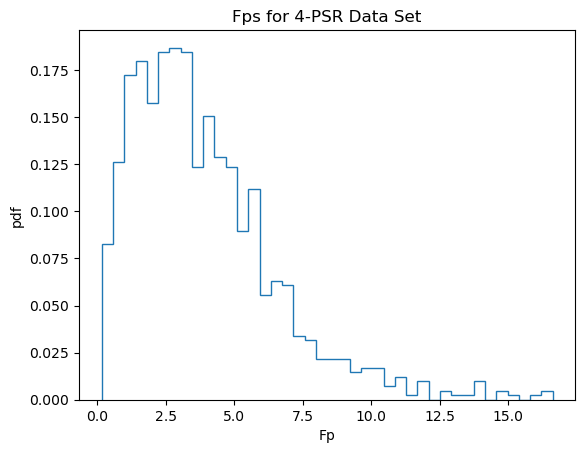

In [50]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True)
plt.title("Fps for 4-PSR Data Set")
plt.xlabel("Fp")
plt.ylabel("pdf")
midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = n

In [51]:
popt, pcov = curve_fit(chisq, midpts, counts, p0=[4])

Text(0, 0.5, 'pdf')

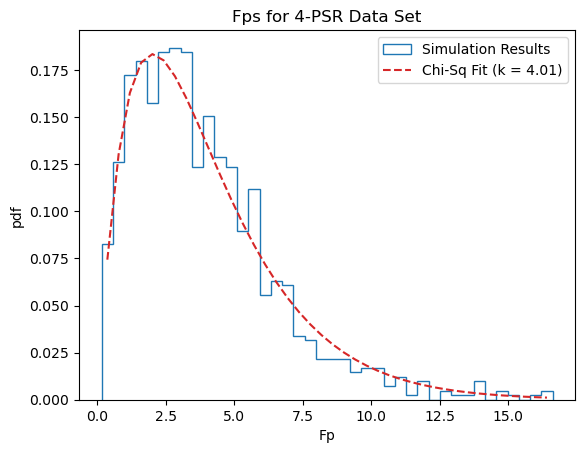

In [52]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(chisq(pt, k=popt[0]))
# plt.plot(midpts, fitted, ls='--', color='tab:orange', label='Chi-Sq Fit (k = {:.02f})'.format(4))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f})'.format(popt[0]))
plt.title("Fps for 4-PSR Data Set")
plt.legend()
plt.xlabel("Fp")
plt.ylabel("pdf")

# WN + BWM

In [7]:
wn_bwm_noisefile = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/noisedict.json'
with open(wn_bwm_noisefile, 'rb') as fin:
    noisedict = json.load(fin)

In [ ]:
from enterprise.pulsar import Pulsar


partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/'
fp_log_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_bwm_idealized_Fps.txt'

burst_epoch = (53000 + 365.25*6) * 24*3600
for realization in range(1000):
    if realization % 50 == 0:
        print("Completed {} of {}".format(realization, 1000))
    with open(fp_log_path, 'a+') as outf:
        realization_psrs = []
        for psrname in psrnames:
            parfile = partim_dir + '{}/{}.par'.format(realization, psrname)
            timfile = partim_dir + '{}/{}.tim'.format(realization, psrname)
            
            realization_psrs.append(Pulsar(parfile,timfile))
        realization_FpStat = FpStat(realization_psrs, noisedict=noisedict)
        outf.write('{}\n'.format(realization_FpStat.compute_Fp_bwm(burst_epoch)))
    

Completed 0 of 1000
[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMDATA
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


Completed 50 of 1000


In [ ]:
from scipy.special import gamma
from scipy.optimize import curve_fit
import scipy.stats as stats
def chisq(x, k = 2):
    prefactor = 1/(2**(k/2) * gamma(k/2))
    postfactor = x**(k/2 - 1) * np.exp(-x/2)
    
    return prefactor*postfactor

def nc_chisq_wrapper(x, dof, nc):
    return stats.ncx2.pdf(x, dof, nc, loc=0, scale=1)

In [ ]:
wn_bwm_fps_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_bwm_idealized_Fps.txt'
fps = np.loadtxt(wn_bwm_fps_path)
twofps = 2*fps

In [ ]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True)
plt.title("Fps for 4-PSR Data Set")
plt.xlabel("Fp")
plt.ylabel("pdf")
midpts = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
counts = n

In [ ]:
popt, pcov = curve_fit(nc_chisq_wrapper,midpts, counts, p0 = [4, 20])

In [ ]:
n, bins, patches = plt.hist(twofps, bins=40, histtype='step', density=True, label='Simulation Results')
fitted = []
for pt in midpts:
    fitted.append(nc_chisq_wrapper(pt, dof=popt[0], nc=popt[1]))
plt.plot(midpts, fitted, ls='--', color='tab:red', label='Chi-Sq Fit (k = {:.02f}, nc = {:.02f})'.format(popt[0], popt[1]))
plt.title("Fps for 4-PSR Data Set")
plt.legend()
plt.xlabel("Fp")
plt.ylabel("pdf")

## It's completely busto. Noise run to make sure the injection WN is okay in WN only

In [35]:
import glob


In [36]:
psrlist = ['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']
partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/0/'
psrs = []

for psrname in psrlist:
    pfile = partim_dir + psrname + '.par'
    tfile = partim_dir + psrname + '.tim'
    psrs.append(Pulsar(pfile,tfile))

efac = parameter.Uniform(0, 10)
# equad = parameter.Constant()
ef = white_signals.MeasurementNoise(efac=efac)
# eq = white_signals.EquadNoise(log10_equad=equad)
tm = gp_signals.TimingModel(use_svd=True)

s =  ef + tm

model = []
for p in psrs:
    model.append(s(p))
wnpta = signal_base.PTA(model)

In [37]:
from enterprise_extensions import sampler as ee_sampler
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import os

Optional mpi4py package is not installed.  MPI support is not available.
Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [39]:
Niter = int(2e5)
outdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/0/WN_noise_run/'
os.makedirs(outdir, exist_ok = True)

sampler=ee_sampler.setup_sampler(wnpta, outdir = outdir)
x0 = np.hstack([p.sample() for p in wnpta.params])

np.savetxt(outdir + 'pars.txt', list(map(str, wnpta.param_names)), fmt='%s')
np.savetxt(outdir + 'priors.txt', list(map(lambda x: str(x.__repr__()), wnpta.params)), fmt='%s')

sampler.sample(x0, Niter, SCAMweight=30, AMweight=15, DEweight=50)

Finished 5.00 percent in 6.315408 s Acceptance rate = 0.256122Adding DE jump with weight 50
Finished 99.50 percent in 122.859636 s Acceptance rate = 0.474744
Run Complete


In [40]:
!pip install la_forge

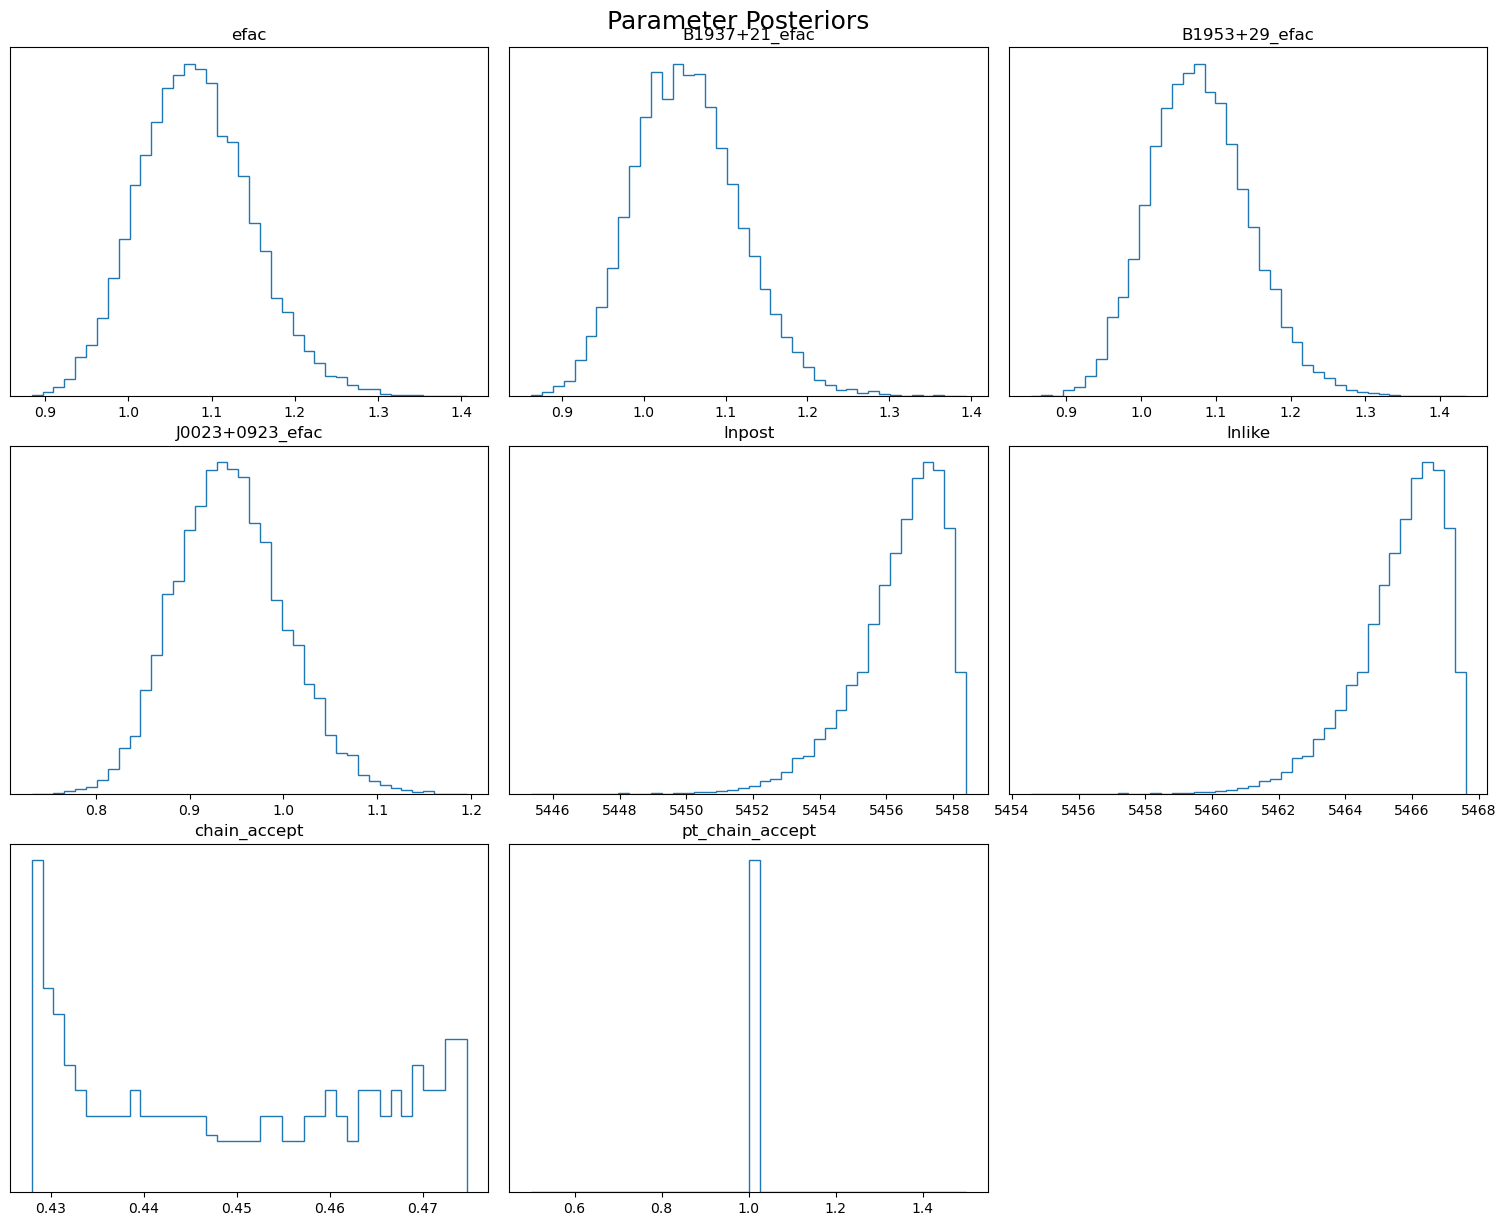

In [42]:
import la_forge
from la_forge.diagnostics import plot_chains
from la_forge.core import Core
import json

chaindir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/0/WN_noise_run/'
wnonly_core = Core(chaindir=chaindir)

plot_chains(wnonly_core)

In [43]:
def make_noise_files(psrname, chain, pars, outdir):
    x = {}
    for ct, par in enumerate(pars):
        x[par] = np.median(chain[:, ct])
    os.system('mkdir -p {}'.format(outdir))
    with open(outdir + '/{}_noise.json'.format(psrname), 'w') as fout:
        json.dump(x, fout, sort_keys=True, indent=4, separators=(',', ': '))
        
def make_noise_dict(psrlist, dir_path, outdir):
    x = {}
    for psrname in psrlist: 
        pars = np.loadtxt(dir_path+'/pars.txt', dtype=np.unicode_)
        chain = np.loadtxt(dir_path+'/chain_1.txt')
        burn = int(0.35 * len(chain))
        for ct, par in enumerate(pars):
            x[par] = np.median(chain[burn:, ct])
        with open(outdir + '/noisedict.json', 'w') as fout:
            json.dump(x, fout, sort_keys=True, indent=4, separators=(',',':'))
        make_noise_files(psrname, chain[burn:,:-4], pars, outdir=outdir)

In [ ]:
print(psrnames)

In [44]:
make_noise_dict(psrnames, chaindir, '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/0/')

# Do noise run on WN + BWM idealized data set

In [69]:
psrlist = ['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']
partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/'
psrs = []

for psrname in psrlist:
    pfile = partim_dir + psrname + '.par'
    tfile = partim_dir + psrname + '.tim'
    psrs.append(Pulsar(pfile,tfile))

efac = parameter.Uniform(0, 10)
# equad = parameter.Constant()
ef = white_signals.MeasurementNoise(efac=efac)
# eq = white_signals.EquadNoise(log10_equad=equad)
tm = gp_signals.TimingModel(use_svd=True)
bwm = ee_blocks.bwm_block(Tmin = min([p.toas.min() for p in psrs]), Tmax = max([p.toas.max() for p in psrs]), )
s =  ef + tm + bwm

model = []
for p in psrs:
    model.append(s(p))
wn_bwm_pta = signal_base.PTA(model)

In [70]:
Niter = int(2e5)
outdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/WN_BWM_noise_run/'
os.makedirs(outdir, exist_ok = True)

sampler=ee_sampler.setup_sampler(wnpta, outdir = outdir)
x0 = np.hstack([p.sample() for p in wnpta.params])

np.savetxt(outdir + 'pars.txt', list(map(str, wnpta.param_names)), fmt='%s')
np.savetxt(outdir + 'priors.txt', list(map(lambda x: str(x.__repr__()), wnpta.params)), fmt='%s')

sampler.sample(x0, Niter, SCAMweight=30, AMweight=15, DEweight=50)

Adding BWM prior draws...

Finished 5.00 percent in 8.160971 s Acceptance rate = 0.368644Adding DE jump with weight 50
Finished 99.50 percent in 149.975476 s Acceptance rate = 0.481623
Run Complete


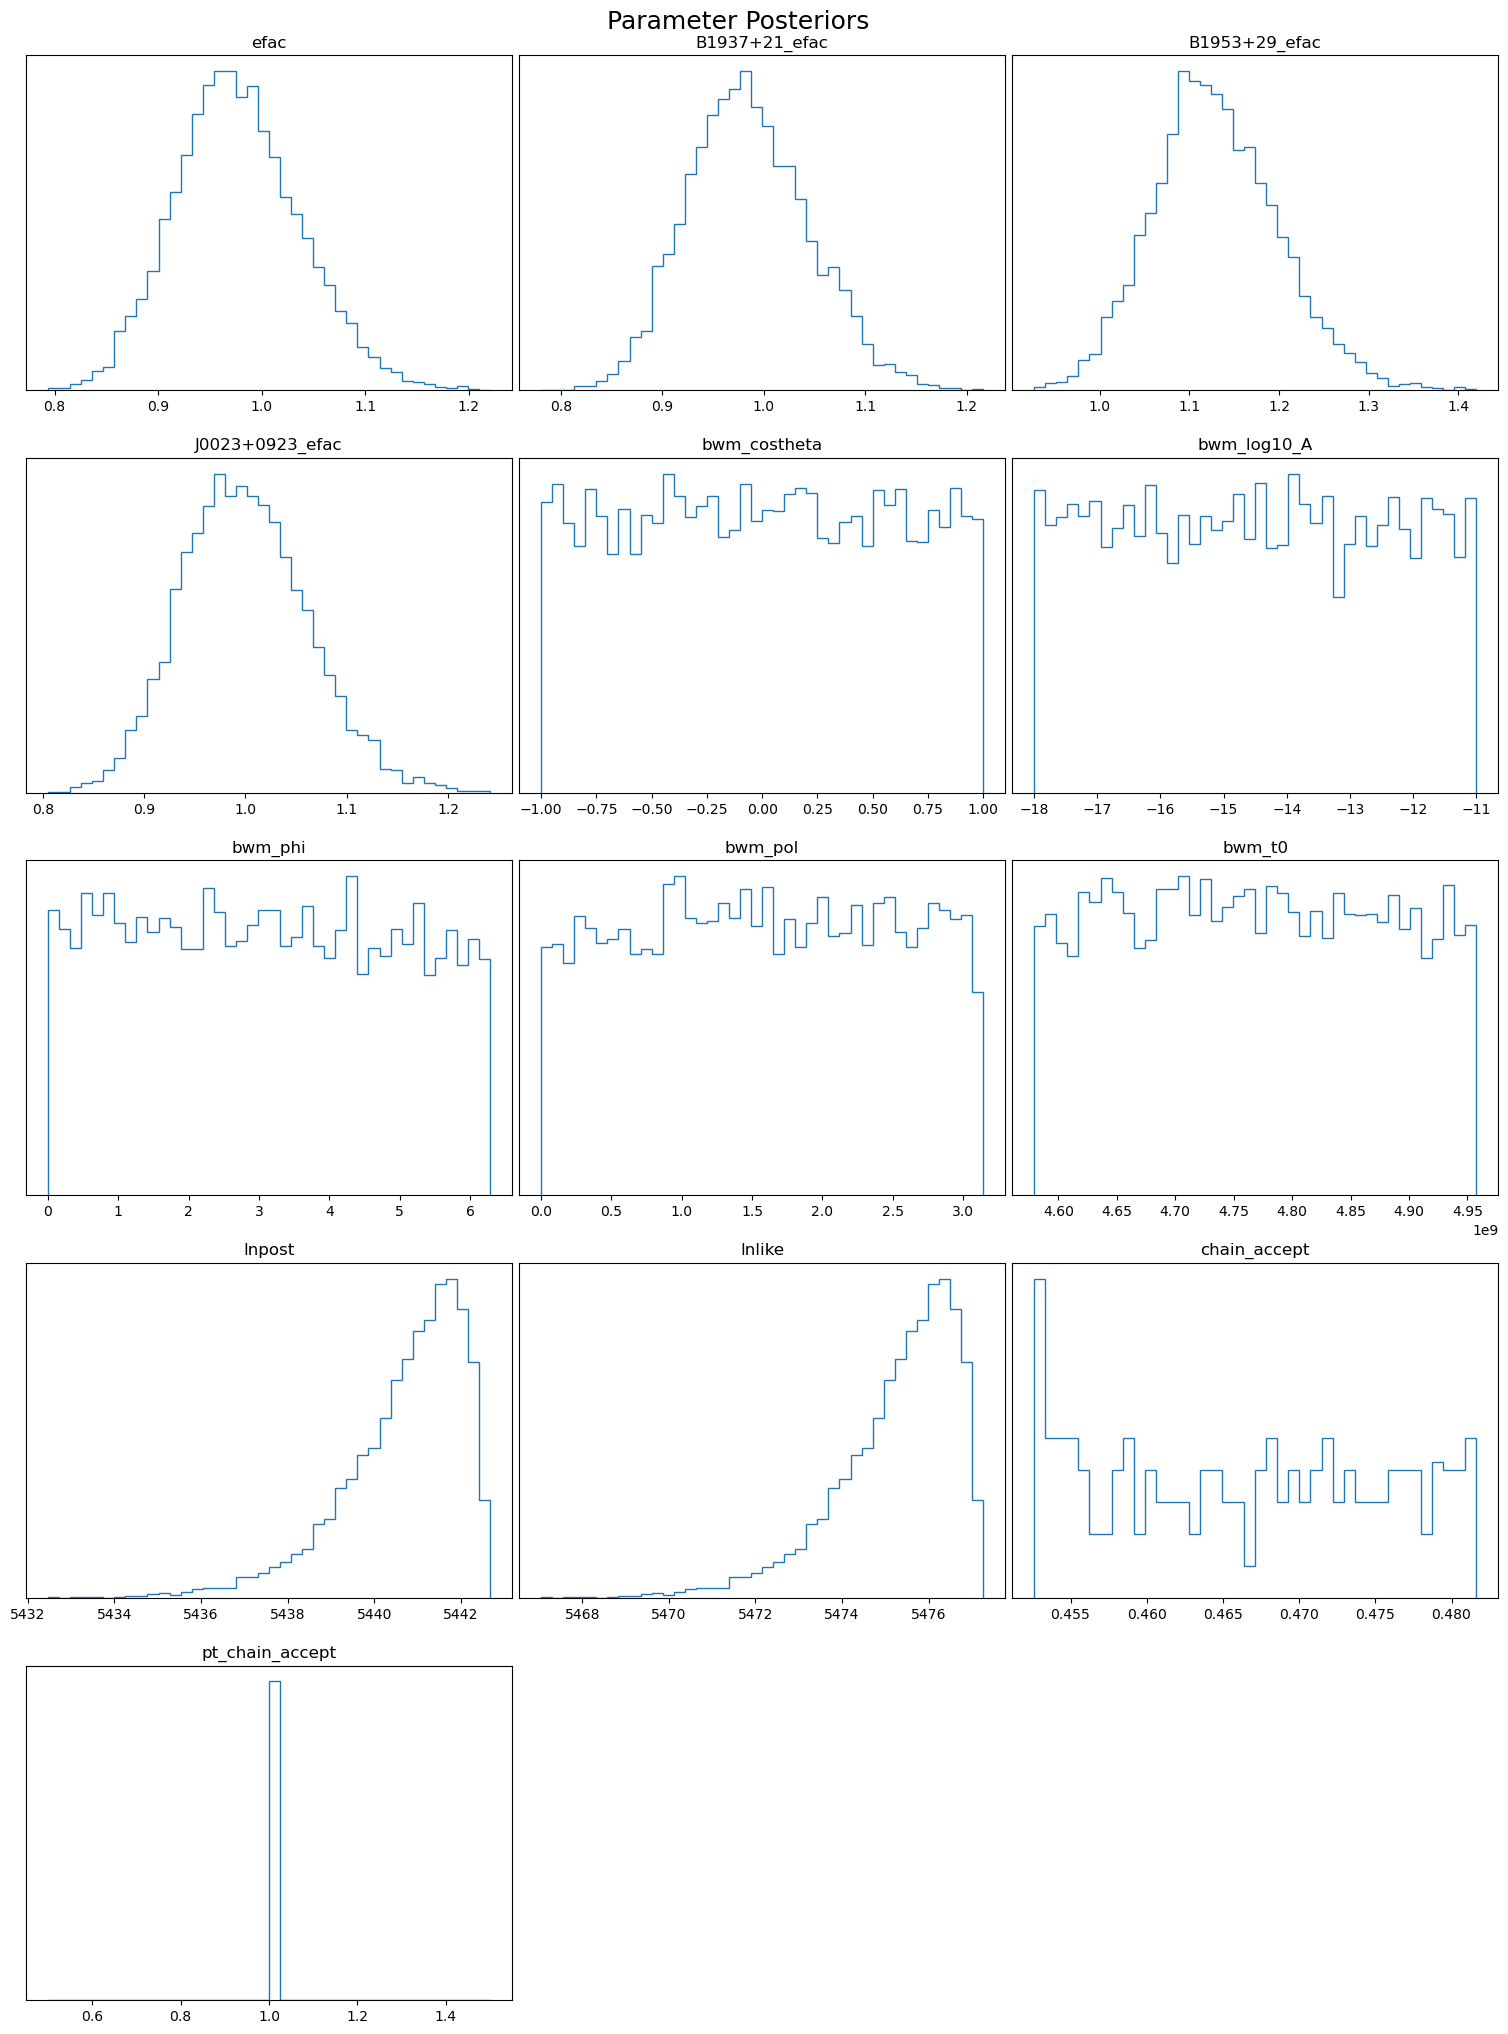

In [72]:
chaindir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/WN_BWM_noise_run/'
wnbwm_core = Core(chaindir=chaindir)

plot_chains(wnbwm_core)

In [73]:
def make_noise_files(psrname, chain, pars, outdir):
    x = {}
    for ct, par in enumerate(pars):
        x[par] = np.median(chain[:, ct])
    os.system('mkdir -p {}'.format(outdir))
    with open(outdir + '/{}_noise.json'.format(psrname), 'w') as fout:
        json.dump(x, fout, sort_keys=True, indent=4, separators=(',', ': '))
        
def make_noise_dict(psrlist, dir_path, outdir):
    x = {}
    for psrname in psrlist: 
        pars = np.loadtxt(dir_path+'/pars.txt', dtype=np.unicode_)
        chain = np.loadtxt(dir_path+'/chain_1.txt')
        burn = int(0.35 * len(chain))
        for ct, par in enumerate(pars):
            x[par] = np.median(chain[burn:, ct])
        with open(outdir + '/noisedict.json', 'w') as fout:
            json.dump(x, fout, sort_keys=True, indent=4, separators=(',',':'))
        make_noise_files(psrname, chain[burn:,:-4], pars, outdir=outdir)

In [75]:
make_noise_dict(psrnames, chaindir, '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/')